# Thema 3 werkcollege 4: Large Language Models
Het trainen van transformer (taal)modellen is een rekenintensieve langdurige gelegenheid die ook nog eens fikse datasets vereist. Gelukkig hoef je dit niet altijd helemaal zelf te doen. In deze les gaan we naar meerdere voorbeelden kijken van pretrained networks. Hiervoor maken we gebruik van de library kerasnlp. Dit pakket is een uitbreiding van Keras waarin een groot aantal voorgetrainde netwerken beschikbaar is. Het doortrainen van een netwerk op een specifieke usecase wordt transfer learning genoemd.

Op BrightSpace heb je gelezen dat er verschillende soorten transformermodellen zijn: encoder-only, decoder-only en encoder-decoder modellen. Enkele van de meest bekende modellen zijn de encoder [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) (Bidirectional Encoder Representations from Transformers), en de decoder [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) (Generative pre-trained transformers ). 

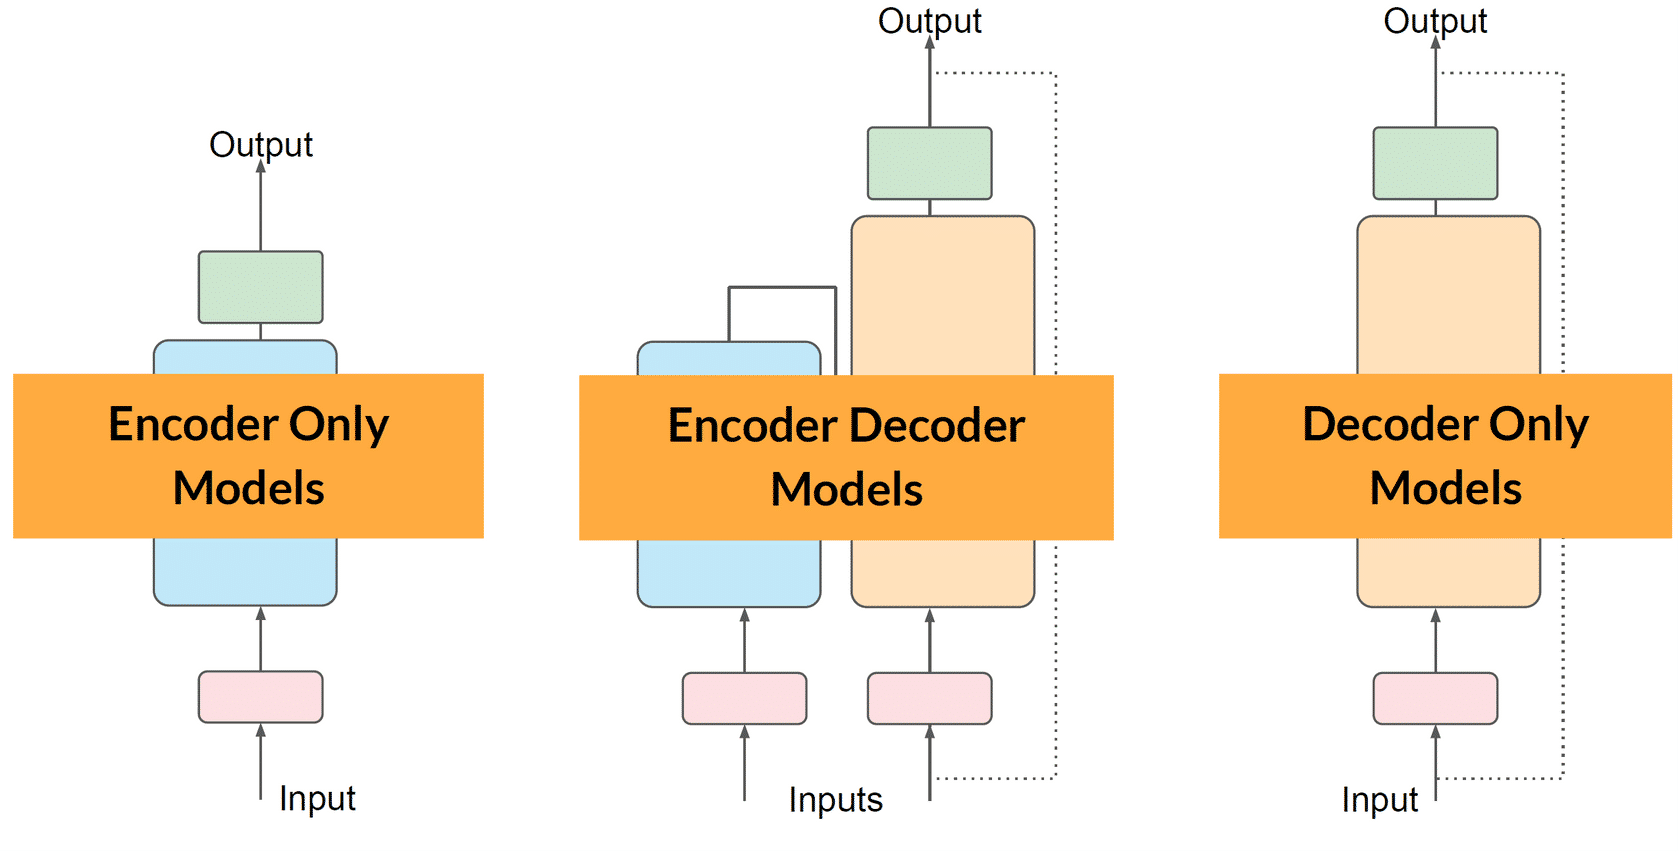 source: <a href="https://deeplearning.ai">deeplearning.ai</a>

Tijdens dit werkcollege gaan we daarom met BERT en GPT-2 werken.

Encoder-only modellen (ook wel autoencoding models genoemd) zijn vooral goed op het gebied classificatie. Belangrijke usecases zijn sentiment analyse, named entity recognition en word classification. Populaire modellen hierbij zijn BERT en ROBERTA (een variant op BERT).


Decoder-only modellen (ook wel autoregressive models genoemd) zijn goed in het genereren van tekst generatie. Dit is de klasse van modellen die ook ander emergent behaviour laat zien. Populaire modellen zijn GPT en BLOOM.


Sequence-to-sequence modellen zijn goed in twee inputstromen verwerken. Belangrijke usecases zijn vertalingen, tekstsamenvatten en vraag&antwoord. Belangrijke modellen zijn T5 en BART.


## Data Preparation
Tijdens deze les werken we weer met de game_review data. Als eerste beginnen we weer met het inlezen en prepareren van de game_review data.

In [2]:
#lees de reviewdata in en zet deze om naar tf data-objecten (gegeven, zie vorige les)
import pandas as pd
df = pd.read_excel('dataset/gamereviews.xlsx')
text =df['reviewText'].astype('str')
sentiment =df['sentiment'].astype('int')
print(text.head())
print(sentiment.head())
print(sentiment.sum())

0    If you're looking for immersive gameplay, good...
1    The zippers on this bag are terrible. I ordere...
2    If you need a good intro to Wii games, this is...
3    This game has brought back so many great memor...
4    True Crime: Streets of LA was my first experie...
Name: reviewText, dtype: object
0    0
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int64
50000


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#gegeven, zie vorige les
train_features, test_features, train_targets, test_targets = train_test_split(
        text, sentiment,
        test_size=0.2,
        shuffle = True,
        stratify=sentiment
    )

In [5]:
#gegeven, zie vorige les
import tensorflow as tf

#omzetten naar tensorflow dataobject met een batch_size van 64
#NB meer infor voor de docent https://www.geeksforgeeks.org/difference-between-dataset-from_tensors-and-dataset-from_tensor_slices/
train_text = tf.data.Dataset.from_tensor_slices(tf.cast(train_features.values, tf.string)).batch(64) #default batch is 32
train_cat = tf.data.Dataset.from_tensor_slices(tf.cast(train_targets.values, tf.int64)).batch(64)  
test_text = tf.data.Dataset.from_tensor_slices(tf.cast(test_features.values, tf.string)).batch(64)  
test_cat = tf.data.Dataset.from_tensor_slices(tf.cast(test_targets.values, tf.int64)).batch(64)   

for each in train_text.take(1): #toon de 1e review
  print(each)

2024-10-10 09:24:44.499485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 09:24:44.520071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 09:24:44.537555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 09:24:44.542447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 09:24:44.556621: I tensorflow/core/platform/cpu_feature_guar

tf.Tensor(
[b"I have played some of the top rated games like Okami on the ps2, Resident evil 4, on the ps2, and Alien vs predator 2 on the pc.  This one has got to be the best out of all the ones I have listed. This game was awarded 2005 game of the year and I can see why. The graphics are the best I have seen on the ps2. It is kind of like  watching a movie. You play Kratos, who has to defeat the God of war, Ares. It is an epic quest that will reveal kratos dark past and the future. You fight different kinds of mythological creatures. The undead legionaire is a reanimated souls trained by Ares. The hydra is a snake-like beast that likes to terrorize the ships on the Aegean Sea. The Minotaur is a bloodthirsty creature that is half-man half bull. You even fight a cyclops that is a one-eyed behemoth. The gorgon was once a woman with long hair and was punished by Athena and was transformed into a snake-like creature and the hair was transformed into snakes. These are some of the creatures

2024-10-10 09:24:49.037416: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
#samenvoegen naar 1 train en test dataset (gegeven, zie vorige les)
train_ds = tf.data.Dataset.zip((train_text,train_cat)) 
test_ds = tf.data.Dataset.zip((test_text,test_cat)) 

for each in train_ds.take(1): #toon de 1e batch
  print(each)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"I have played some of the top rated games like Okami on the ps2, Resident evil 4, on the ps2, and Alien vs predator 2 on the pc.  This one has got to be the best out of all the ones I have listed. This game was awarded 2005 game of the year and I can see why. The graphics are the best I have seen on the ps2. It is kind of like  watching a movie. You play Kratos, who has to defeat the God of war, Ares. It is an epic quest that will reveal kratos dark past and the future. You fight different kinds of mythological creatures. The undead legionaire is a reanimated souls trained by Ares. The hydra is a snake-like beast that likes to terrorize the ships on the Aegean Sea. The Minotaur is a bloodthirsty creature that is half-man half bull. You even fight a cyclops that is a one-eyed behemoth. The gorgon was once a woman with long hair and was punished by Athena and was transformed into a snake-like creature and the hair was transformed in

2024-10-10 09:24:49.261580: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Encoder-only transformers: Sentimentanalyse met BERT
Dan nu ons 1e BERT model. Zoals hierboven als gesteld is bevat BERT alleen een encoder deel van een transformer en ontbreekt de decoder. Globaal gezien ziet dit er als volgt uit. 

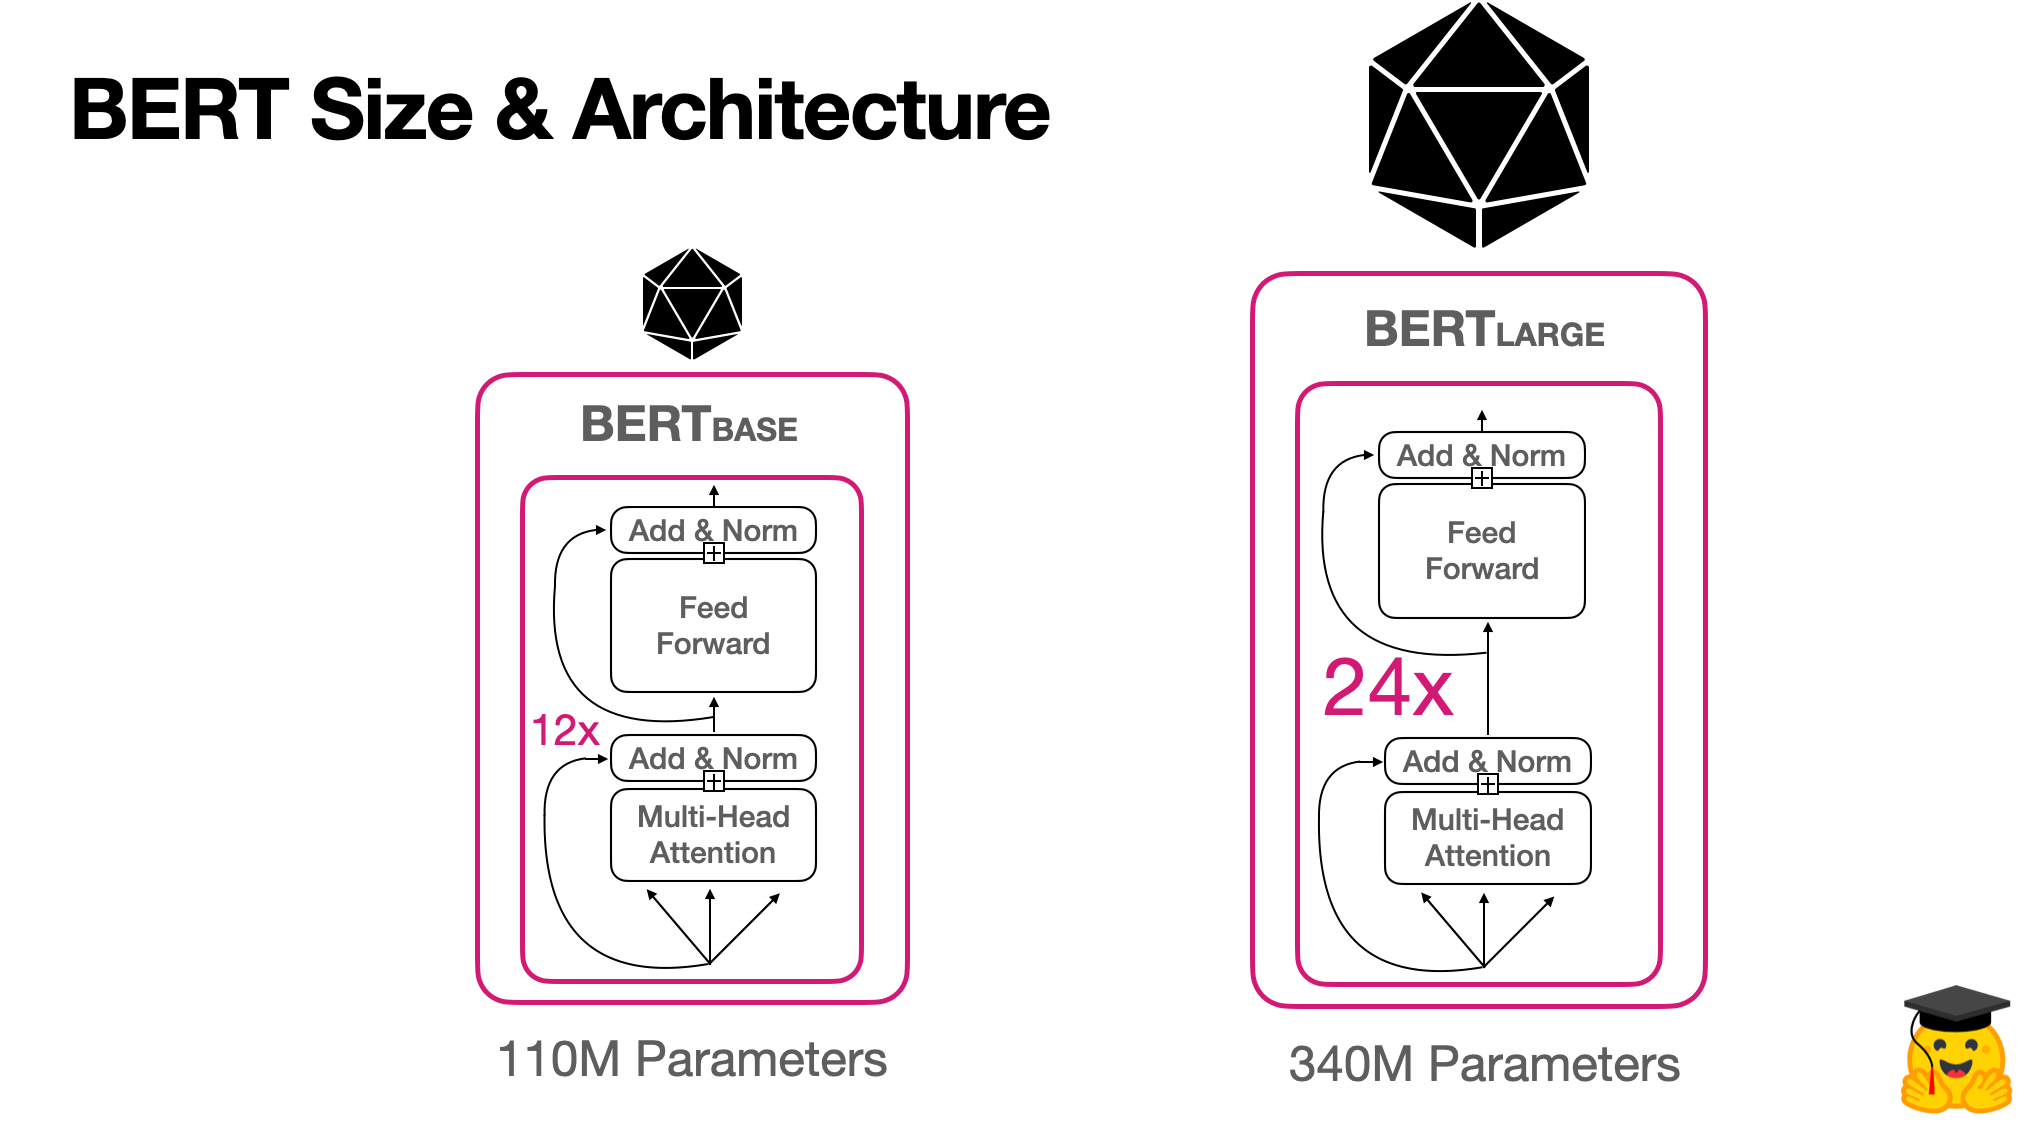 source: https://huggingface.co/blog/bert-101

Zoals je ziet lijkt dit heel erg op in de vorige les behandelde encoder deel van de transformer. Alleen kent deze wat meer transformerblocks en is al voorgetraind.  Dit laatste is natuurlijk heel handig ivm de beschikbare tijde en rekenkracht


Op https://keras.io/api/keras_nlp/models/bert/ staat een hele uitleg over hoe je BERT kunt gebruiken. Kort gesteld hebben we een backbone wat het eigenlijk BERT model bevat en een aantal voorgedefineerde variaties erop die het leven een stukje makkelijker maken. Zo bestaat er o.a. een voorgedefineerd BERT model voor classificatie. Dit bevat de BERT backbone met een extra dropout en dense layer voor het classificatiedeel. In deze les maken we het ons zelf wat moeilijker en gebruiken we ***alleen de backbone*** (het originele BERT-model) en voegen we zelf een aantal layers die we nodig hebben voor de classificatie toe. 

NB: Beperk je ivm de performance tot "bert_tiny_en_uncased". 

Het volgende model is Pre-trained op Engelstalige Wikipedia en nog wat datasets
Hoe zorg je dat dat ding doet wat je wil:

**Extra layers toevoegen** 

**Extra kolommen aan tensor toevoegen** <- later in dit notebook nog

**Model doortrainen** -> kost heel veel tijd en rekenkracht. Risico: model vergeet alles wat ie al geleerd heeft.  <- Laatste redmiddel



In [7]:
#Laad het BERT model en geef de summary
import keras_nlp
bert = keras_nlp.models.BertBackbone.from_preset("bert_tiny_en_uncased")
bert.summary()

Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 128) │  3,906,816 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 128) │     65,536 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_embedding   │ (None, None, 128) │        256 │ segment_ids[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 128) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
│                     │                   │            │ segment_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 128) │        256 │ embeddings_add[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 128) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 128) │    198,272 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 128) │    198,272 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ transformer_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_dense        │ (None, 128)       │     16,512 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,385,920 (16.73 MB)

 Trainable params: 4,385,920 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

Wat kun je over de achitectuur van het model zeggen?

## BERT Finetunen
We hebben nu een voorgetraind BERT-model geladen wat een goede kennis heeft van de engelse taal, maar hiermee kunnen we nog geen sentimenten gaan voorspellen. Hiervoor moeten we BERT nog gaan finetunen op onze specifieke situatie.

Over het algemeen bestaat finetuning uit de volgende stappen: 
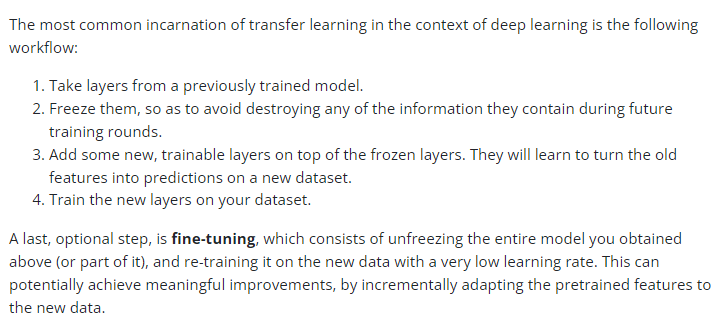
Bron: https://keras.io/guides/transfer_learning/

In [8]:
# Zet het Bert model op trainable=false en geef opnieuw de summary (kijk vooral naar verschillen met hierboven)
bert.trainable = False #bevriezen trainbaarheid model
bert.summary()

Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 128) │  3,906,816 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 128) │     65,536 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_embedding   │ (None, None, 128) │        256 │ segment_ids[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 128) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
│                     │                   │            │ segment_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 128) │        256 │ embeddings_add[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 128) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 128) │    198,272 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 128) │    198,272 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ transformer_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_dense        │ (None, 128)       │     16,512 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,385,920 (16.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,385,920 (16.73 MB)

In [9]:
#laad de Bert preprocesser en map onze train en test dataset hierop zie https://keras.io/guides/keras_nlp/getting_started/ 
preprocessor =keras_nlp.models.BertPreprocessor.from_preset(
    "bert_tiny_en_uncased",
    sequence_length=512,
)

train_ds_preprocessed = (
    train_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
test_ds_preprocessed = (
    test_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

100%|██████████| 547/547 [00:00<00:00, 899kB/s]


100%|██████████| 226k/226k [00:00<00:00, 522kB/s]


In [10]:
# voeg een dropout en een dense-layer toe zie bijv https://keras.io/guides/keras_nlp/getting_started/ 
# onder finetuning a custom model
import keras 
inputs = bert.input
x = bert(inputs)['sequence_output']
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(2)(x[:,bert.cls_token_index, :] )
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 128) │          0 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128)       │          0 │ dropout_2[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        258 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 4,385,920 (16.73 MB)

In [11]:
#compile het model (copy paste uit het voorbeeld in de keras documentatie, ik heb alleen geen adamW)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)

In [12]:
# fit de dataset (5 epochs)
history = model.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=3,
)

Epoch 1/3


2024-10-10 09:25:08.564271: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1728552311.900936    2296 service.cc:146] XLA service 0x7f2528005b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728552311.901043    2296 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX350, Compute Capability 6.1
2024-10-10 09:25:12.116483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 09:25:13.083737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1728552321.606266    2296 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 732/1250 ━━━━━━━━━━━━━━━━━━━━ 1:29 172ms/step - loss: 0.9170 - sparse_categorical_accuracy: 0.4938

KeyboardInterrupt: 

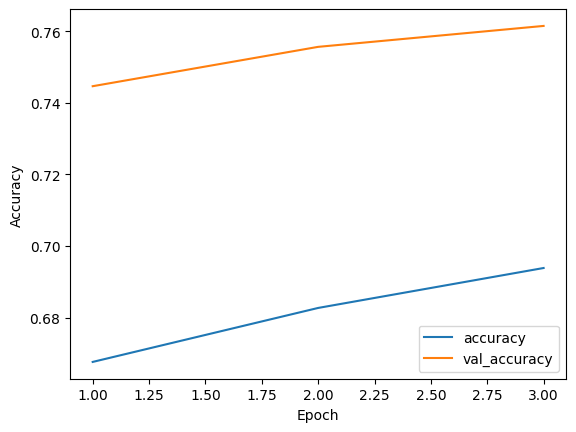

In [27]:
#plot de accuracy en val accuracy 
import matplotlib.pyplot as plt 
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Wat kun je zeggen over de resultaten?

Nu zijn de resultaten nog niet helemaal zo hoog als we zouden willen. Een mogelijke verklaring is dat dit komt doordat (game) reviews een aantal specifieke termen bevatten waar ons tiny_bert model nog niet goed op is getraind. Daarom voegen we als extra een (trainbare) transformer encoder toe voor onze dropout layer. Volg het voorbeeld op https://keras.io/guides/keras_nlp/getting_started/ maar dan 1 transformerencoder en zonder dropout.

In [29]:
#pas het model aan met 1 transformer encoder
inputs = bert.input
x = bert(inputs)["sequence_output"] 
x= keras_nlp.layers.TransformerEncoder(num_heads=2, intermediate_dim=512)(x)
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(2)(x[:, bert.cls_token_index, :])
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    198,272 │ bert_backbone[3]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128)       │          0 │ dropout_4[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ get_item_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,584,450 (17.49 MB)

 Trainable params: 198,530 (775.51 KB)

 Non-trainable params: 4,385,920 (16.73 MB)

Epoch 1/3


2024-10-07 12:10:25.377907: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads

2024-10-07 12:10:27.141882: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 4 bytes spill stores, 4 bytes spill loads

2024-10-07 12:10:27.167013: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_55', 2824 bytes spill stores, 2824 bytes spill loads

2024-10-07 12:10:27.239971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 324 bytes spill stores, 272 bytes spill loads

2024-10-07 12:10:27.359485: I external/local_xla/xla/stream_exec

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.6464

2024-10-07 12:11:45.153711: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads

2024-10-07 12:11:45.593692: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 324 bytes spill stores, 272 bytes spill loads



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 57ms/step - loss: 0.7155 - sparse_categorical_accuracy: 0.6465 - val_loss: 0.4443 - val_sparse_categorical_accuracy: 0.7947
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - loss: 0.4733 - sparse_categorical_accuracy: 0.7749 - val_loss: 0.4013 - val_sparse_categorical_accuracy: 0.8198
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - loss: 0.4334 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.3833 - val_sparse_categorical_accuracy: 0.8308


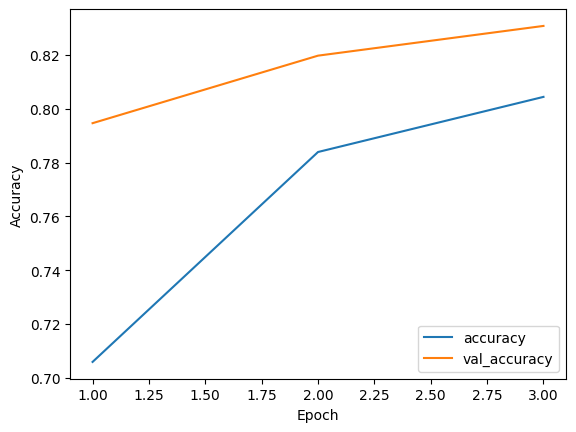

In [30]:
#compile, fit (epochs=3) en plot de accuracy en validated accuracy
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
history=model.fit(train_ds_preprocessed, epochs=3, validation_data=test_ds_preprocessed)
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Heeft dit veel effect?


Ja, flink veel effect

We hebben nu een stukje transferlearning toegepast waarbij we de voorgetrainde BERT backbone hebben gebruik en de extra classificatielayers er omheen hebben getraind. Nu wordt er in het bovengenoemde stappenplan ook gesproken over een optionele extra stap, namelijk het opnieuw trainen van het hele model met een heel lage learning rate.  Wees hier wel heel voorzichtig mee want we lopen een groot risico alles wat ons BERT-model pretrained meebracht meteen weer kwijt te raken. Om dit te voorkomen zijn er aan aantal dingen van belang: 
1. Ten eerste trainen we met een ***hele lage learning rate*** zodat we niet te snel alle bestaande weights allemaal overschrijven. 
2. We ***beperken ons aantal epochs*** tot niet meer dan een paar.
3. We ***setten training=False***. We hadden al trainable=False gezien wat ervoor zorgde dat we de backbone niet konden trainen. trainable=False doet net iets anders, dit zorgt er namelijk voor dat we alleen de dropout en batchnormalisation layers niet kunnen trainen.


In [31]:
# Zet de bert backbone op trainbaar, maar set trainig op False en geef de summary. Check het aantal trainbare parameters
bert.trainable=True #unfreeze de backbone
bert.training=False #bevries alle dropout en normalisation layers
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    198,272 │ bert_backbone[3]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128)       │          0 │ dropout_4[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ get_item_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,981,512 (19.00 MB)

 Trainable params: 4,584,450 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 397,062 (1.51 MB)

In [32]:
# Compile het model met een lage learning rate (5e-5)en fit het hele BERT model op onze dataset (epochs=1). 
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
history=model.fit(train_ds_preprocessed, epochs=1, validation_data=test_ds_preprocessed)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 91ms/step - loss: 0.3394 - sparse_categorical_accuracy: 0.8524 - val_loss: 0.2169 - val_sparse_categorical_accuracy: 0.9152


Soort doodzonde in de machine learning wereld omdat we het hele model opnieuw aan het trainen zijn. Als je dit met meer epochs doet vergeet ie dus alles wat je weet. LAATSTE REDMIDDEL

Wat kun je zeggen over de resultaten? 

Trainen kost een stuk meer tijd. De accuracy is wel echt een stuk beter.

In [33]:
# Opruimen voordat we naar het nieuwe onderdeel gaan, anders ben je snel door je geheugen heen
del model
del history
del bert

## Decoder-only modellen: Sentimentanalyse met GPT-2
We hebben nu gekeken naar een encoder-only model: BERT. Kenmerkend aan dit model is dat er discrete output neuronen zijn die gebruikt kunnen worden om mee te classificeren. 

In het tweede deel van dit werkcollege gaan we kijken naar generatieve oplossingen. Daar vallen zowel de encoder-decoder als de decoder-only modellen onder. Bij een encoder-decoder model geef je een prompt, waarna het model een nieuwe output genereert. Bij een decoder model geef je ook een prompt, maar breidt het model de prompt uit met extra woorden: de completion. 

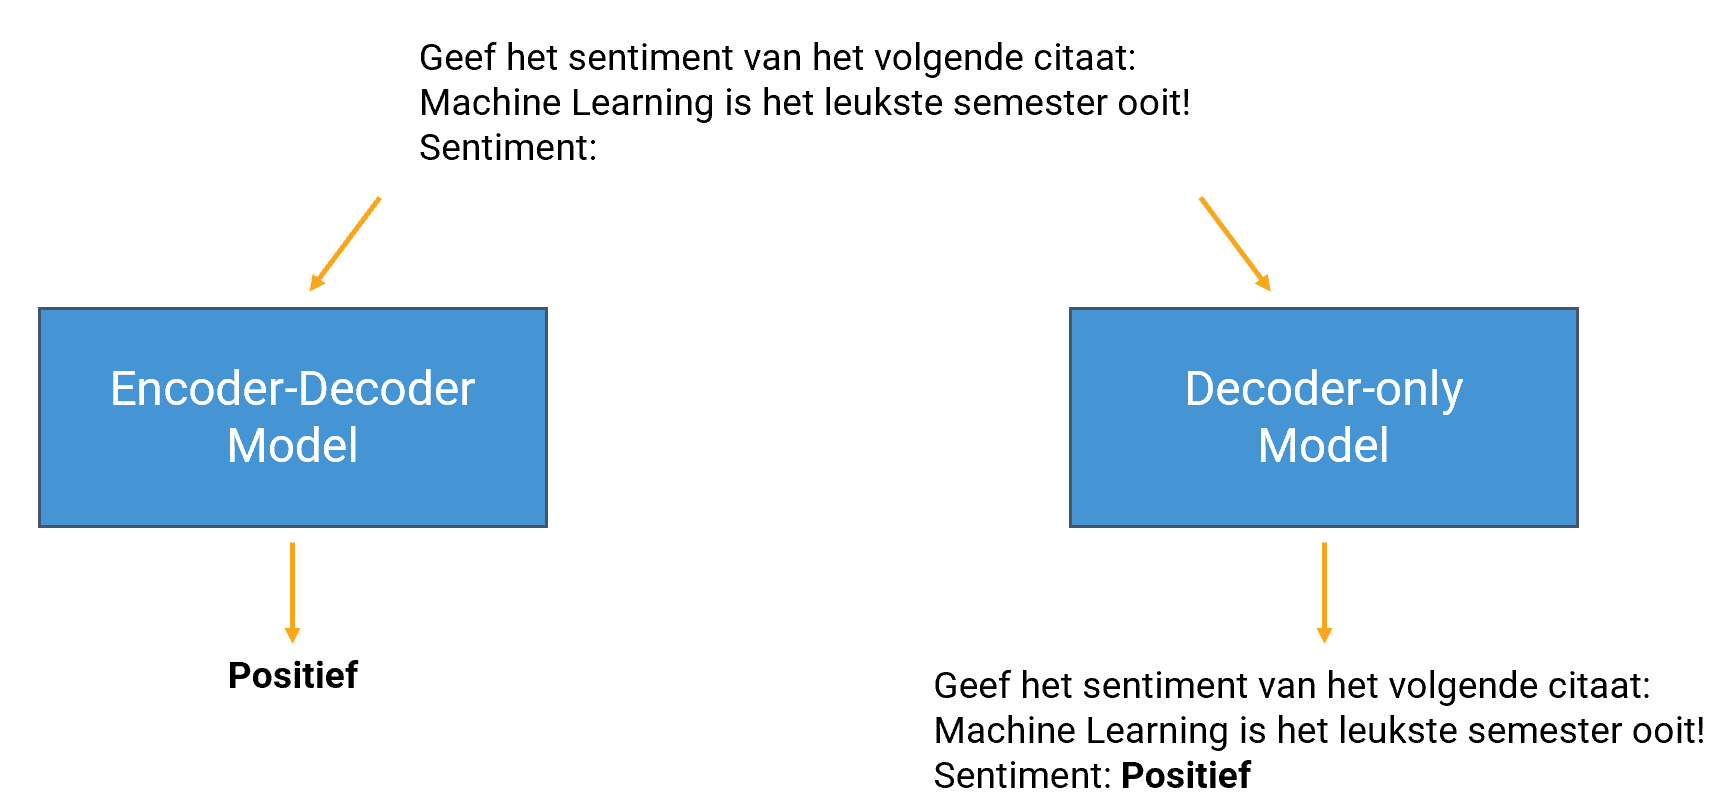

### Model
In deze les kijken we naar het GPT-2 model. Dit is een decoder-only model. 

Als eerste halen we het model op

In [34]:
from tensorflow import keras
policy = keras.mixed_precision.Policy("mixed_float16") # Beperk het geheugengebruik van je model
keras.mixed_precision.set_global_policy(policy)

import keras_nlp
import tensorflow as tf
import pandas as pd

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


I0000 00:00:1728304322.431285    1177 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [35]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length = 100,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor
)

100%|██████████| 484/484 [00:00<00:00, 393kB/s]


100%|██████████| 448/448 [00:00<00:00, 1.14MB/s]


100%|██████████| 0.99M/0.99M [00:00<00:00, 1.43MB/s]


100%|██████████| 446k/446k [00:00<00:00, 1.14MB/s]


100%|██████████| 475M/475M [00:32<00:00, 15.1MB/s] 


Bekijk onderstaand model. Hoeveel transformerlagen zitten er in het GPT2 model?

In [36]:
gpt2_lm.backbone.summary()

Model: "gpt2_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None,      │ 38,597,376 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │ 50257)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    786,432 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 768) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 768) │          0 │ embeddings_add[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 768) │  7,087,872 │ embeddings_dropo… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_6 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_7 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_8 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_9 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

### Dataset
We gaan opnieuw aan de slag met de dataset over gamedata. Importeer de data uit de file en maak een dataframe waarin er één kolom 'fulltext' is met de hele text van de review en één kolom met het sentiment. Beperk je tot 500 samples.

In [37]:
# Importeer hier de dataset opnieuw en stop deze in een dataframe
def get_dataset(N=500):
    df = pd.read_excel('gamereviews.xlsx')
    text = df['reviewText'].astype('str')
    sentiment = df['sentiment'].astype('int')
    return pd.DataFrame({'fulltext': text[:N].values, 'sentiment': sentiment[:N].values})

df = get_dataset()
df.head(2)

,fulltext,sentiment
0,"If you're looking for immersive gameplay, good...",0
1,The zippers on this bag are terrible. I ordere...,0


We maken een _template_ om een opdracht mee te geven aan het model. Dit passen we vervolgens toe op de dataset. We maken daarbij twee datasets: een inclusief het antwoord en een zonder het antwoord.

In [38]:
template = "Classify the sentiment:\n{0}\nSentiment:{1}"

In [45]:
# Maak twee datasets: ds_with_completion en ds_without_completion. Het verschil tussen beiden is dat 
# het ene ook de uitvoer bevat. Beperk de citaatlengte tot maximaal 60 woorden, anders wordt het te 
# gortig voor het model. 
ds = gpt2_lm.preprocessor.generate_postprocess(preprocessor(df['fulltext'].astype(str), sequence_length=60)[0])

ds_with_completion = [template.format(sentence," Positive" if label==1 else " Negative") for sentence, label in zip(ds, df['sentiment'])]
ds_without_completion = [template.format(sentence, "") for sentence, label in zip(ds, df['sentiment'])]


In [46]:
print(ds_with_completion[0])

Classify the sentiment:
If you're looking for immersive gameplay, good story and graphics...then don't buy this game.  At first I thought this would be a Max Payne knock-off, which would be fine because that was a great game.  Unfortunately this game can't even be put into the same category
Sentiment: Negative


In [47]:
print(ds_without_completion[0])

Classify the sentiment:
If you're looking for immersive gameplay, good story and graphics...then don't buy this game.  At first I thought this would be a Max Payne knock-off, which would be fine because that was a great game.  Unfortunately this game can't even be put into the same category
Sentiment:


Splits als laatste je data in train en testsamples. Je mag 10% overhouden voor testen.

In [48]:
# Gegeven: Maak een test/train split
ds_with_completion_train, ds_with_completion_test, ds_without_completion_train, ds_without_completion_test = train_test_split(ds_with_completion, ds_without_completion, test_size=0.1)

### Prompt Engineering
We gaan als eerste kijken hoe het model zich gedraagt als we nog niks getraind hebben. De hoop is daarbij dat het model genoeg voorkennis heeft om het goed te doen. Geef daarvoor het eerste record uit de dataset (zonder completion) aan het model en kijk hoe het zich gedraagt:

In [49]:
# Gegeven: support functie om makkelijk te printen

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def infer_and_print(model, prompt, max_length=100) -> None:
    """Infer the result based on the prompt. Print the output in boldfaced."""
    
    inference = model.generate(prompt, max_length = max_length)

    print(prompt, color.BOLD, inference[len(prompt):], color.END)


In [51]:
prompt = ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt)

Classify the sentiment:
I am a huge fan of the scarface movie and Al Pacino movies in general. I remember Scarface had resurfaced in popularity in New York during the time of this game, and I bought it the week it came out. I kept seeing those commercials and reviews and the game looks like
Sentiment:  
I think that the character is very cool. I don't know if it is a fan favorite, but if you look at the game it looks 


Hoe goed presteert je model?

Komt wel tekst uit het model, maar nog niet alleen 'positive' of 'negative' Dus we krijgen niet het antwoord wat we willen

Probeer in je prompt nu één of meerdere voorbeelden mee te geven van correcte antwoorden, voordat je het definitieve model geeft

In [53]:
# One-shot inference: geef eerst een volledig voorbeeld mee
prompt =  ds_with_completion_test[1] +'\n\n' + ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt, 200)

Classify the sentiment:
I want to make this review rather short. First, it's an easy to install Gamepad and looks very promising. You have the easy PS2 feel, dual-analog control pads, and a comfortable fit. You can install the drivers or not. It doesn't really make a difference
Sentiment: Negative

Classify the sentiment:
I am a huge fan of the scarface movie and Al Pacino movies in general. I remember Scarface had resurfaced in popularity in New York during the time of this game, and I bought it the week it came out. I kept seeing those commercials and reviews and the game looks like
Sentiment:   Negative

Classify the sentiment:

I am very happy with my purchase and would not buy it again. It's a great game and I will continue to buy it. It is a very nice game with very high quality. It is also a very good game. I will 


In [55]:
# Few shot inference: geef enkele voorbeelden mee
prompt = ds_with_completion_test[1] + '\n\n' + ds_with_completion_test[2] + '\n\n' + ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt, 300)

Classify the sentiment:
I want to make this review rather short. First, it's an easy to install Gamepad and looks very promising. You have the easy PS2 feel, dual-analog control pads, and a comfortable fit. You can install the drivers or not. It doesn't really make a difference
Sentiment: Negative

Classify the sentiment:
It does not work with WII
Sentiment: Negative

Classify the sentiment:
I am a huge fan of the scarface movie and Al Pacino movies in general. I remember Scarface had resurfaced in popularity in New York during the time of this game, and I bought it the week it came out. I kept seeing those commercials and reviews and the game looks like
Sentiment:   Positive

Classify the sentiment:

It's not that great. The game is not a great experience and it is not a great experience for me, so I will probably just give the game 4 stars. The game itself isn't great and I'm not sure what I would like to do with the game if it didn't work out for me. The music is good, but I'm not s

Wat is nu de kwaliteit van je model?


 Zoals je kunt ziet geeft prompt engineering je de kans om het model in de goede richting te duwen zonder dat het model getraind hoeft te worden. Helaas zijn de resultaten nog niet heel consistent en blijft het extra output genereren. Het model 'hallucineert' en verzint compleet nieuwe prompt vragen! 


Laten we nu gaan kijken of we door middel van fine-tuning het model beter kunnen maken.

### Finetunen van het hele model
We geven alvast wat instellingen weg om goed te kunnen doortrainen met het model. Belangrijkste aspect in onderstaande is dat de learning rate erg laag is. Was deze hoger, dan zou het model erg snel het al geleerde vergeten.

In [57]:
# We maken gebruik van het AdamW algoritme in plaats van Adam. Dit is een net iets efficienter model voor deze taak.
# De parameters zijn de aanbevolen instellingen voor het finetunen van een LLM.
import keras
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-5,
    weight_decay=0.01,
    epsilon=1e-6,
    global_clipnorm=1.0,  # Gradient clipping.
)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

gpt2_lm.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

gpt2_lm.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,439,808 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

Fit nu je data. Zorg ervoor dat je een Dataset object gebruikt met lage batchgrootte om het werkbaar te houden. 

Je bent hiermee aan het fine-tunen op het gehele model. Let erop dat je niet meer dan een of twee epocht draait. Ga je langer door, dan heb je namelijk meer risico op catastrophic forgetting.

In [58]:
# Converteer indien nog niet gedaan hier je trainingset (with completion) tot een Dataset object.
# Kies voor een lage batchsize om het werkbaar te houden voor je laptop (hint: ik kan 5 aan)

ds_with_completion_train_as_dataset = tf.data.Dataset.from_tensor_slices(ds_with_completion_train).batch(5)

In [59]:
# Fit nu het model met één epoch. Gebruik de trainingsset with completion.
gpt2_lm.fit(ds_with_completion_train_as_dataset, epochs=1)

W0000 00:00:1728306530.077842    1338 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-07 13:09:04.079822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_476', 4 bytes spill stores, 4 bytes spill loads

2024-10-07 13:09:04.435827: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_476', 16 bytes spill stores, 16 bytes spill loads

2024-10-07 13:09:04.544904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_476', 4 bytes spill stores, 4 bytes spill loads

2024-10-07 13:09:04.714198: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warnin

90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - accuracy: 0.3217 - loss: 2.2615


Test nu je model voor een aantal samples. Klopt je output?

In [60]:
prompt = ds_without_completion_test[0]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
I am a huge fan of the scarface movie and Al Pacino movies in general. I remember Scarface had resurfaced in popularity in New York during the time of this game, and I bought it the week it came out. I kept seeing those commercials and reviews and the game looks like
Sentiment:   Negative 


In [61]:
prompt = ds_without_completion_test[1]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
I want to make this review rather short. First, it's an easy to install Gamepad and looks very promising. You have the easy PS2 feel, dual-analog control pads, and a comfortable fit. You can install the drivers or not. It doesn't really make a difference
Sentiment:   Negative 


In [62]:
prompt = ds_without_completion_test[18]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
the blue bomber in all his games mostly, its a nice lil collection..not bad for the price and something a lil hard to find
Sentiment:   Negative 


### Parameter efficient fine-tuning middels LORA
Zoals we in het bovenstaande voorbeeld hebben mogen zien, bestaat het GPT2 model uit 126 miljoen trainbare vrije parameters. Voor elke vrije parameter heb je nog eens 10x zoveel geheugenruimte nodig voor de onderdelen van de optimalisator. In totaal kan dat dus een flinke aanslag zijn op je geheugencapaciteit. Gelukkig is er een alternatief: Parameter efficient fine-tuning. Bij PEFT-methoden wordt niet het hele model getraind, maar slechts een deel daarvan. 

In onderstaande sectie kijken we naar de zogenaamde Low-Rank Adaptation. Hierbij wordt het oorspronkelijke model bevroren. In plaats daarvan wordt aan de output van de  transformerlaag extra vrije parameters opgeteld. Door wat slimme wiskunde wordt dat aantal vrije parameters zelfs nog lager. Je eindigd daardoor met slechts een fractie van het aantal vrije parameters.

Deze sectie dient slechts ter verdieping op het onderwerp en mag bij tijdnood overgeslagen worden. We volgen hier https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/

In [63]:
# LoRA-specific hyperparameters
RANK = 4 #aantal neuronen die je per layer toevoegt
ALPHA = 32.0 #Verhoogt weging neuronen die je hebt

Onderstaande code laat de definitie zien van de LoraLayer. Je kan zien hoe het oorspronkelijk Transformerlaag wordt gebruikt en uitgebreid met de Lora-specifieke code.

In [64]:
import math

class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=RANK,
        alpha=ALPHA,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

Voor de training laden we opnieuw het model. Om het geheugen te beperken verwijderen we het model uit de vorige sectie.

In [ ]:
del gpt2_lm
del optimizer
del loss

In [74]:
# This resets "peak" memory usage to "current" memory usage.
#tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
lora_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

Hier vervangen we de oorspronkelijke transformerlagen met de nieuwe Lora-lagen.

In [75]:
for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer
    # Allow mutation to Keras layer state.
    self_attention_layer._tracker.locked = False

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

Stel het model zo in dat enkel de Lora-componenten getraind kunnen worden.

In [76]:
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

Hier stellen we opnieuw alles in voor het trainen. Let in het bijzonder op het aantal vrije parameters.

In [77]:
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-5,
    weight_decay=0.01,
    epsilon=1e-6,
    global_clipnorm=1.0,  # Gradient clipping.
)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lora_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)


lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,439,808 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 124,439,808 (474.70 MB)

Fit het model weer aan de trainingsset. Je zult nu wat meer epochs nodig hebben om een goed resultaat te hebben. Ga uit van 10 epochs.

In [78]:
# Fit hier je model op de trainingset with completion (10 epochs)
lora_model.fit(ds_with_completion_train_as_dataset, epochs=10)

Epoch 1/10


W0000 00:00:1728308494.643187    1350 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.2648 - loss: 2.0130
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.2672 - loss: 1.9703
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.2728 - loss: 1.9113
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2851 - loss: 1.8538
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2950 - loss: 1.8015
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3125 - loss: 1.7577
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3230 - loss: 1.7102
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3393 - loss: 1.6645
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3469 - loss: 1.6315
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3623 - loss: 1.5887


Test het resultaat van je fit. Wat is de kwaliteit van je model? Helpt verder doortrainen nog?

In [79]:
prompt = ds_without_completion_test[0]

infer_and_print(lora_model, prompt, 100)

Classify the sentiment:
I am a huge fan of the scarface movie and Al Pacino movies in general. I remember Scarface had resurfaced in popularity in New York during the time of this game, and I bought it the week it came out. I kept seeing those commercials and reviews and the game looks like
Sentiment:   negative 


In [80]:
prompt = ds_without_completion_test[1]

infer_and_print(lora_model, prompt, 100)

Classify the sentiment:
I want to make this review rather short. First, it's an easy to install Gamepad and looks very promising. You have the easy PS2 feel, dual-analog control pads, and a comfortable fit. You can install the drivers or not. It doesn't really make a difference
Sentiment:   Positive 


Het model heeft vergelijkbare prestaties als de vorige code. Wel valt op dat de accuracy nog altijd laag is. Mogelijk helpt verder trainen daarbij nog.